# Contents



1. Imports
    - import packages <br>
2. Data
    - define directory path<br>
    - read raw data csv files into pandas for both original and reduced datasets from directory<br>
    - create summary statistic table with length of training and test sets and number of occupation labels<br>
    - create occupation frequency chart for original data set<br>
3. Utility Functions
    - define some utility functions<br>
4. Graphs
    - clean original test dataset by removing words that are not included in the training vocabulary<br>
    - build feature vectors and one hot labels for original test data<br>
    - load feature vectors, one hot labels and adjacency matrix for original training data from directory<br>
5. Model
    - define intialisation functions<br>
    - define layers<br>
    - define training metrics<br>
    - define model<br>
6. Prediction
    - load GCN trained with original dataset with gender indicators<br>
    - predict occupation labels for original dataset<br>
7. Analyses
    - calculate TPR, TPR gender gap and $\pi_{g,y}$ for the gender "female"<br>
    - plot for $\text{Gap}_{female,y}$ and $\pi_{female,y}$ and compute correlation <br>
    - compute gender imbalance and compounding factor<br>
    - load predictions on scrubbed test dataset<br>
    - TPR, TPR gender gap and correlation between TPR gender gap and $\pi_{female,y}$ on scrubbed dataset<br>
    - plot of $\text{Gap}_{female,y}$ and $\pi_{female,y}$ for original compared to scrubbed test dataset<br>
    - proportion of compounding factors pulled towards 1 after scrubbing

# Imports

In [ ]:
import pickle
import csv
import random
from sklearn import preprocessing
import pandas as pd 
import numpy as np
from google.colab import drive
from nltk.corpus import stopwords
import nltk
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
import sys
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import re
import os
from math import log
from sklearn import svm
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
# colab will be updated to tensorflow 2.x soon
%tensorflow_version 1.x 
import tensorflow as tf
from __future__ import division
from __future__ import print_function
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import timeit

TensorFlow 1.x selected.


# Data

## Load Data

Choose whether you would like to perform data cleaning which takes an additional 8 mins (True) or load cleaned data to save time (False)

In [ ]:
clean = True

Please define the path to directory where data is saved below.

In [ ]:
alldatapath = './all data'
testdatapath = './test data'
trainedmodelpath = './trained model'
traininggraph = './training graph'

In [ ]:
base_set = pd.read_csv('{}/preprocessed.csv'.format(alldatapath)) # complete dataset
base_set_1000 = pd.read_csv('{}/preprocessed_1000.csv'.format(alldatapath)) # complete dataset
occupation_dict = np.array(pd.read_csv('{}/occupation.csv'.format(alldatapath), header=None)) # occupations + coded occupations
g = np.array(base_set.iloc[round(0.7 * len(base_set)):, base_set.columns.get_loc('gender')]) # gender labels for test set


## Summary Statistics

In [ ]:
summary = pd.DataFrame({'train size': [round(0.7 * len(base_set)), round(0.7 * len(base_set_1000))],
                        'test size': [len(base_set)-round(0.7 * len(base_set)), len(base_set_1000)-round(0.7 * len(base_set_1000))],
                        'no. labels': [len(np.unique(base_set['label'])),len(np.unique(base_set_1000['label']))]})
summary.index= ['original', 'reduced']
display(summary)                                   

,train size,test size,no. labels
original,68459,29339,28
reduced,65475,28061,19


## Occupation Frequencies

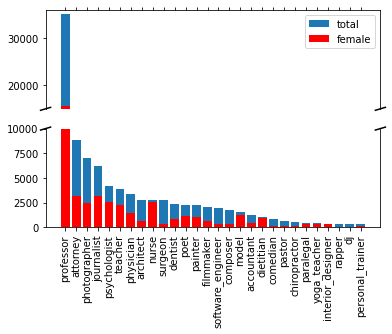

In [ ]:
y_total = np.array(base_set['label']) # all occupation labels
g_total = np.array(base_set['gender']) # all gender labels

lbl, cnts = np.unique(y_total, return_counts=True)
cnts_sorted, lbl_sorted = zip(*sorted(list(zip(cnts, lbl)), reverse=True))
new_dict = dict(occupation_dict)
plot_labels = [new_dict[label] for label in lbl_sorted]

f = [i for i, x in enumerate(np.array(g_total)) if np.array(g_total)[i]=='F']
y_total_f = y_total[f]

lbl_f, cnts_f = np.unique(y_total_f, return_counts=True)  
cnts_sorted_f_orig, lbl_sorted_f_orig = zip(*sorted(list(zip(cnts_f, lbl_f)), reverse=True))
new_dict = dict(occupation_dict)
plot_labels_f_orig = [new_dict[label] for label in lbl_sorted_f_orig]

zipped = list(zip(plot_labels_f_orig, cnts_sorted_f_orig))
zipped_ordered = []
for i in range(len(plot_labels)):
  for j in range(len(plot_labels)):
    if plot_labels[i] in zipped[j]:
        zipped_ordered.append(zipped[j])
plot_labels_f, cnts_sorted_f = zip(*zipped_ordered)

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
total = ax.bar(range(len(plot_labels)), cnts_sorted, label = 'total')
female = ax.bar(range(len(plot_labels_f)), cnts_sorted_f, color='r', label = 'female')
ax2.bar(range(len(plot_labels)), cnts_sorted)
ax2.bar(range(len(plot_labels_f)), cnts_sorted_f, color='r')

# zoom-in / limit the view to different portions of the data
ax.set_ylim(15000, 36000)  # outliers only
ax2.set_ylim(0, 10000)  # most of the data

# hide the spines between ax and ax2
plt.xticks(range(len(plot_labels)), plot_labels, rotation=90)
ax.spines['bottom'].set_visible(False)
ax.xaxis.tick_top()
ax2.spines['top'].set_visible(False)

d = .015  
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.legend(loc ='upper right')

plt.show()

# Utility Functions


In [ ]:
def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def load_corpus(test_data_str,train_data_str):
    """
    Loads input corpus from gcn/data directory
    ind.dataset_str.x => the feature vectors of the training docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training docs/words
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training docs as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test docs as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.adj => adjacency matrix of word/doc nodes as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.train.index => the indices of training docs in original doc list.
    All objects above must be saved using python pickle module.
    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """

    train_names = ['x', 'y']  # add in 'graph'
    test_names = ['tx','ty']
    train_names2 = ['allx', 'ally', 'adj']
    objects = []
    for i in range(len(train_names)):
        with open("{}/ind.{}.{}".format(traininggraph, train_data_str, train_names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    for i in range(len(test_names)):
        with open("{}/ind.{}.{}".format(testdatapath, test_data_str, test_names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    for i in range(len(train_names2)):
      with open("{}/ind.{}.{}".format(traininggraph, train_data_str, train_names2[i]), 'rb') as f:
          if sys.version_info > (3, 0):
              objects.append(pkl.load(f, encoding='latin1'))
          else:
              objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, adj = tuple(objects)
    print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

    features = sp.vstack((allx, tx)).tolil()
    labels = np.vstack((ally, ty))
    print(len(labels))

    train_idx_orig = parse_index_file("{}/{}.train.index".format(traininggraph,train_data_str))
    train_size = len(train_idx_orig)

    val_size = train_size - x.shape[0]
    test_size = tx.shape[0]

    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + val_size)
    idx_test = range(allx.shape[0], allx.shape[0] + test_size)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i]
                      for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def clean_data(test_data, train_data):
  p = open('{}/vocab.txt'.format(alldatapath), 'rb')
  vocab = pkl.load(p)
  p.close

  doc_content_list = []
  f = open('{}/{}.txt'.format(testdatapath, test_data), 'rb')
  for line in f.readlines():
      doc_content_list.append(line.strip().decode('latin1'))
  f.close()

  clean_docs = []
  for doc_content in doc_content_list:
      temp = clean_str(doc_content)
      words = temp.split()
      doc_words = []
      for word in words:
          if word in vocab:
              doc_words.append(word)

      doc_str = ' '.join(doc_words).strip()

      clean_docs.append(doc_str)

  clean_corpus_str = '\n'.join(clean_docs)

  f = open('{}/{}.clean.txt'.format(testdatapath, test_data), 'w')
  f.write(clean_corpus_str)
  f.close()

  print('{} cleaned!'.format(test_data))

def transform_test_data(test_data):
  if(test_data == 'bio' or test_data =='scrub' or test_data =='swap'):
    len_train = round(0.7 * len(base_set)) # length of training set
    len_test = len(base_set)-len_train # length of test set
  elif(test_data == 'bio_1000' or test_data =='scrub_1000' or test_data =='swap_1000'):
    len_train = round(0.7 * len(base_set_1000)) # length of training set
    len_test = len(base_set_1000)-len_train # length of test set
  else: print('wrong test data')

  word_embeddings_dim = 300
  word_vector_map = {}
  label_list = list(map(str,occupation_dict[:,0]))

  doc_test_list = []
  f = open('{}/{}_label.txt'.format(testdatapath, test_data), 'r')
  lines = f.readlines()
  for line in lines:
      doc_test_list.append(line.strip())
  f.close()

  test_ids = range(len_train,len_train + len_test)
  test_ids_str = '\n'.join(str(index) for index in test_ids)
  f = open('{}/{}.test.index'.format(testdatapath,test_data),'w')  
  f.write(test_ids_str)
  f.close()

  doc_content_list = []
  f = open('{}/{}.clean.txt'.format(testdatapath, test_data), 'r')
  lines = f.readlines()
  for line in lines:
    doc_content_list.append(line.strip())
  f.close()

  # tx: feature vectors of test docs, no initial features
  test_size = len(test_ids)
  print(test_size)

  row_tx = []
  col_tx = []
  data_tx = []
  for i in range(test_size):
      doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
      doc_words = doc_content_list[i]
      words = doc_words.split()
      doc_len = len(words)
      for word in words:
          if word in word_vector_map:
              word_vector = word_vector_map[word]
              doc_vec = doc_vec + np.array(word_vector)

      for j in range(word_embeddings_dim):
          row_tx.append(i)
          col_tx.append(j)
          # np.random.uniform(-0.25, 0.25)
          data_tx.append(doc_vec[j] / doc_len)  # doc_vec[j] / doc_len

  # tx = sp.csr_matrix((test_size, word_embeddings_dim), dtype=np.float32)
  tx = sp.csr_matrix((data_tx, (row_tx, col_tx)),
                    shape=(test_size, word_embeddings_dim))
  print(tx.shape)
  ty = []
  for i in range(test_size):
      doc_meta = doc_test_list[i]
      temp = doc_meta.split('\t') #
      label = temp[2]
      one_hot = [0 for l in range(len(label_list))]
      label_index = label_list.index(label)
      one_hot[label_index] = 1
      ty.append(one_hot)
  ty = np.array(ty)
  print(ty.shape)

  f = open("{}/ind.{}.ty".format(testdatapath, test_data), 'wb')
  pkl.dump(ty, f)
  f.close()
  
  f = open("{}/ind.{}.tx".format(testdatapath, test_data), 'wb')
  pkl.dump(tx, f)
  f.close()

  print('{} test data feature vectors and one hot labels saved!'.format(test_data))

# Graph

## Clean Test Dataset

In [ ]:
if(clean == True):

  start = timeit.default_timer()

  clean_data('bio', 'bio') # takes a 8 mins in total

  stop = timeit.default_timer()
  print('Time: ', stop - start)  

bio cleaned!
Time:  417.7702201269999


##Build Graph

In [ ]:
transform_test_data('bio')

29339
(29339, 300)
(29339, 28)
bio test data feature vectors and one hot labels saved!


# Model

## Initialisations

In [ ]:
def glorot(shape, name=None):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def zeros(shape, name=None):
    """All zeros."""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)


## Layers

In [ ]:
#from inits import *

flags = tf.app.flags
FLAGS = flags.FLAGS

# global unique layer ID dictionary for layer name assignment
_LAYER_UIDS = {}


def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs."""
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]


def sparse_dropout(x, keep_prob, noise_shape):
    """Dropout for sparse tensors."""
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)


def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = tf.sparse_tensor_dense_matmul(x, y)
    else:
        res = tf.matmul(x, y)
    return res


class Layer(object):
    """Base layer class. Defines basic API for all layer objects.
    Implementation inspired by keras (http://keras.io).
    # Properties
        name: String, defines the variable scope of the layer.
        logging: Boolean, switches Tensorflow histogram logging on/off
    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
        _log_vars(): Log all variables
    """

    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.sparse_inputs = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            if self.logging and not self.sparse_inputs:
                tf.summary.histogram(self.name + '/inputs', inputs)
            outputs = self._call(inputs)
            if self.logging:
                tf.summary.histogram(self.name + '/outputs', outputs)
            return outputs

    def _log_vars(self):
        for var in self.vars:
            tf.summary.histogram(self.name + '/vars/' + var, self.vars[var])

class GraphConvolution(Layer):
    """Graph convolution layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0.,
                 sparse_inputs=False, act=tf.nn.relu, bias=False,
                 featureless=False, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.support = placeholders['support']
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            for i in range(len(self.support)):
                self.vars['weights_' + str(i)] = glorot([input_dim, output_dim],
                                                        name='weights_' + str(i))
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # convolve
        supports = list()
        for i in range(len(self.support)):
            if not self.featureless:
                pre_sup = dot(x, self.vars['weights_' + str(i)],
                              sparse=self.sparse_inputs)
            else:
                pre_sup = self.vars['weights_' + str(i)]
            support = dot(self.support[i], pre_sup, sparse=True)
            supports.append(support)
        output = tf.add_n(supports)

        # bias
        if self.bias:
            output += self.vars['bias']
        self.embedding = output #output
        return self.act(output)


## Training Metrics

In [ ]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    print(preds)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))

    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

## GCN

In [ ]:
class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model
        self.activations.append(self.inputs)
        for layer in self.layers:
            hidden = layer(self.activations[-1])
            self.activations.append(hidden)
        self.outputs = self.activations[-1]

        # Store model variables for easy access
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

        # Build metrics
        self._loss()
        self._accuracy()

        self.opt_op = self.optimizer.minimize(self.loss)

    def predict(self):
        pass

    def _loss(self):
        raise NotImplementedError

    def _accuracy(self):
        raise NotImplementedError

    def load(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = trainedmodelpath+"/%s.ckpt" % self.name
        saver.restore(sess, save_path)
        print("Model restored from file: %s" % save_path)


class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])
        self.pred = tf.argmax(self.outputs, 1)
        self.labels = tf.argmax(self.placeholders['labels'], 1)

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            featureless=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x, #
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [ ]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('f', '', 'kernel')
# 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_string('model', 'gcn', 'Model string.')
flags.DEFINE_float('learning_rate', 0.02, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_float('dropout', 0, 'Dropout rate (1 - keep probability).') # changed from 0.5
flags.DEFINE_integer('hidden1', 200, 'Number of units in hidden layer 1.')
flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')  # 5e-4
flags.DEFINE_integer('early_stopping', 10,'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [ ]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

#del_all_flags(tf.flags.FLAGS)

In [ ]:
# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders,model):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(
        features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy, model.pred, model.labels], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], outs_val[2], outs_val[3], (time.time() - t_test)

# Prediction

##  Load GCN Trained on Original Dataset with Gender Indicators

In [ ]:
num_supports = 1
model_func = GCN
session_conf = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=session_conf)
flags.DEFINE_string('test_data', 'bio', 'train_data string.')
flags.DEFINE_string('train_data', 'bio', 'test_data string.')

adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus(FLAGS.test_data, FLAGS.train_data)
features = sp.identity(features.shape[0])  
features = preprocess_features(features)
support = [preprocess_adj(adj)]
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    # helper variable for sparse dropout
    'num_features_nonzero': tf.placeholder(tf.int32)
}

(61614, 300) (61614, 28) (29339, 300) (29339, 28) (98922, 300) (98922, 28)
128261


In [ ]:
train_data = 'bio'
model1 = model_func(placeholders, input_dim=features[2][1], logging=True)
model1.load(sess=sess)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("graphconvolution_2/SparseTensorDenseMatMul/SparseTensorDenseMatMul:0", shape=(?, 28), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/NLP/trained model/gcn.ckpt
Model restored from file: /content/gdrive/My Drive/NLP/trained model/gcn.ckpt


## Predictions for Original Test Dataset

In [ ]:
test_cost, test_acc, pred, labels, test_duration = evaluate(features, support, y_test, test_mask, placeholders,model1)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

bio_test_pred = []
test_labels = []
print(len(test_mask))
for i in range(len(test_mask)):
    if test_mask[i]:
        bio_test_pred.append(pred[i])
        test_labels.append(labels[i])

print("Test Precision, Recall and F1-Score...")
print(metrics.classification_report(test_labels, bio_test_pred, digits=4))
print("Macro average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, bio_test_pred, average='macro'))
print("Micro average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, bio_test_pred, average='micro'))

Test set results: cost= 0.75392 accuracy= 0.77674 time= 4.10298
128261
Test Precision, Recall and F1-Score...
              precision    recall  f1-score   support

           0     0.7560    0.6563    0.7026       387
           1     0.6821    0.6470    0.6641       796
           2     0.8481    0.8582    0.8531      2686
           3     0.9018    0.6312    0.7426       160
           4     0.7824    0.7602    0.7711       246
           5     0.7996    0.7425    0.7700       532
           6     0.9385    0.8890    0.9131       721
           7     0.7527    0.7721    0.7623       272
           8     0.7391    0.5368    0.6220        95
           9     0.7312    0.7300    0.7306       574
          10     0.8438    0.4696    0.6034       115
          11     0.6606    0.7421    0.6990      1865
          12     0.7435    0.7155    0.7292       478
          13     0.7003    0.6551    0.6769       838
          14     0.7934    0.7450    0.7684       706
          15     0.8182  

# Analyses

## TPR, TPR gender gap and $\pi_{g,y}$ for the gender "female"

In [ ]:
def tpr(y_hat, y, g):

  '''
  y_hat:    list/vector of predictions
  y:        list/vector of true labels
  g:        list of genders ('M', 'F') corresponding to y

  returns two lists of TPRs (male, female) sorted by
  the occupation code in ascending order
  '''

  import numpy as np
  from sklearn.metrics import confusion_matrix

  # male 	
  m = [i for i, x in enumerate(np.array(g)) if np.array(g)[i]=='M']
  y_hat_m = np.array(y_hat)[m]
  y_m = y[m]
  conf_mat_m = confusion_matrix(y_m, y_hat_m)
  tp_m = np.diag(conf_mat_m)
  fn_m = conf_mat_m.sum(axis=1) - np.diag(conf_mat_m)
  tpr_m = tp_m/(tp_m+fn_m)

  # female
  f= [i for i, x in enumerate(np.array(g)) if np.array(g)[i]=='F']
  y_hat_f = np.array(y_hat)[f]
  y_f = y[f]
  conf_mat_f = confusion_matrix(y_f, y_hat_f)
  tp_f = np.diag(conf_mat_f)
  fn_f = conf_mat_f.sum(axis=1) - np.diag(conf_mat_f)
  tpr_f = tp_f/(tp_f+fn_f)

  return(tpr_m, tpr_f)

def gap(tpr_m, tpr_f, gender="F"):
  
  '''
  tpr_m:    list of TPRs for male
  tpr_f:    list of TPRs for female
  gender:   string indicating whether the gap 
            should be calculated from the female
            ('F') or male ('M') perspective with
            default 'F'

  returns a list of TPR gender gaps for the chosen
  gender sorted by the occupation code in ascending order
  '''

  if gender=="F":
    gap = tpr_f - tpr_m
  if gender == "M":
    gap = tpr_m - tpr_f

  return(gap)

def prob_pi(y, g, gender='F'):

  '''
  y:        list/vector of true labels
  g:        list of genders ('M', 'F') corresponding to y
  gender:   string indicating whether the probability 
            should be calculated from the female
            ('F') or male ('M') perspective with
            default 'F'

  returns a list of probabilities for the chosen
  gender given an occupation sorted by the occupation code 
  in ascending order
  '''

  from collections import Counter

  # totals
  total_g = len(g)
  total_y = len(y)
  arr_y = np.array(sorted(Counter(y).items()), dtype=np.dtype('int,int'))
  arr_y.dtype.names=['codes', 'counts']
  counts_y = arr_y['counts']
  p_y = counts_y/total_y # P(Y=y)

  # gender filter	
  indx = [i for i, x in enumerate(np.array(g)) if np.array(g)[i]==gender]
  p_g = len(indx)/total_g # P(G=g)
  y_g = np.array(y)[indx]
  total_y_g = len(y_g)
  arr_y_g = np.array(sorted(Counter(y_g).items()), dtype=np.dtype('int,int'))
  arr_y_g.dtype.names=['codes', 'counts']
  counts_y_g = arr_y_g['counts']
  p_y_g = counts_y_g/total_y_g # P(Y=y|G=g)

  # pi
  p_g_y = (p_y_g*p_g)/p_y # P(G=g|Y=y)

  return(p_g_y)

In [ ]:
tpr_m, tpr_f = tpr(np.array(bio_test_pred), np.array(test_labels), g)
gap_f = gap(tpr_m, tpr_f, gender= 'F')
prob_pi_f = prob_pi(np.array(test_labels), g, gender='F')

## Plot $\text{Gap}_{female,y}$ against $\pi_{female,y}$ and compute correlation

In [ ]:
def plot_gender_gap(prob_pi_g, gap_g, occupation_dict, gender='F'):

  '''
  prob_pi_g:         list of probabilities for occupations for the chosen
                     gender
  gap_g:             list of TPR gender gaps for the chosen
                     gender
  occupation_dict:   zipped list of coded occuation labels and corresponding
                     occupation labels
  gender:            chosen gender with 'F' as default

  returns a plot of the TPR gender gaps against the probability
  of a gender given the occupation
  '''

  import matplotlib.pyplot as plt

  # scatterplot
  plt.plot(prob_pi_g, gap_g, 'b.')
  
  # x and y labels
  if gender=="F":
    plt.xlabel("% Female")
  else:
    plt.xlabel("% Male")
  plt.ylabel("TRP Gender Gap")
  
  # add occupation labels for each point
  _, occupation = zip(*occupation_dict)
  coordinates = list(zip(occupation, prob_pi_g, gap_g))
  #for x in coordinates: plt.annotate(x[0], (x[1],x[2]), textcoords="offset points",xytext=(0,10),ha='left', fontsize='small')
  plt.annotate(coordinates[0][0], (coordinates[0][1],coordinates[0][2]), textcoords="offset points",xytext=(4,16),ha='left', fontsize='small')
  plt.annotate(coordinates[1][0], (coordinates[1][1],coordinates[1][2]), textcoords="offset points",xytext=(0,5),ha='left', fontsize='small')
  plt.annotate(coordinates[2][0], (coordinates[2][1],coordinates[2][2]), textcoords="offset points",xytext=(-11,10),ha='left', fontsize='small')
  plt.annotate(coordinates[3][0], (coordinates[3][1],coordinates[3][2]), textcoords="offset points",xytext=(-35,-10),ha='left', fontsize='small')
  plt.annotate(coordinates[4][0], (coordinates[4][1],coordinates[4][2]), textcoords="offset points",xytext=(-3,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[5][0], (coordinates[5][1],coordinates[5][2]), textcoords="offset points",xytext=(-1,-10),ha='left', fontsize='small')
  plt.annotate(coordinates[6][0], (coordinates[6][1],coordinates[6][2]), textcoords="offset points",xytext=(-20,7),ha='left', fontsize='small')
  plt.annotate(coordinates[7][0], (coordinates[7][1],coordinates[7][2]), textcoords="offset points",xytext=(-25,7),ha='left', fontsize='small')
  plt.annotate(coordinates[8][0], (coordinates[8][1],coordinates[8][2]), textcoords="offset points",xytext=(-8,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[9][0], (coordinates[9][1],coordinates[9][2]), textcoords="offset points",xytext=(-20,6),ha='left', fontsize='small')
  plt.annotate(coordinates[10][0], (coordinates[10][1],coordinates[10][2]), textcoords="offset points",xytext=(-30,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[11][0], (coordinates[11][1],coordinates[11][2]), textcoords="offset points",xytext=(0,-10),ha='left', fontsize='small')
  plt.annotate(coordinates[12][0], (coordinates[12][1],coordinates[12][2]), textcoords="offset points",xytext=(-8,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[13][0], (coordinates[13][1],coordinates[13][2]), textcoords="offset points",xytext=(-10,7),ha='left', fontsize='small')
  plt.annotate(coordinates[14][0], (coordinates[14][1],coordinates[14][2]), textcoords="offset points",xytext=(10,-10),ha='left', fontsize='small')
  plt.annotate(coordinates[15][0], (coordinates[15][1],coordinates[15][2]), textcoords="offset points",xytext=(0,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[16][0], (coordinates[16][1],coordinates[16][2]), textcoords="offset points",xytext=(0,7),ha='left', fontsize='small')
  plt.annotate(coordinates[17][0], (coordinates[17][1],coordinates[17][2]), textcoords="offset points",xytext=(0,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[18][0], (coordinates[18][1],coordinates[18][2]), textcoords="offset points",xytext=(-50,-12),ha='left', fontsize='small')
  plt.annotate(coordinates[19][0], (coordinates[19][1],coordinates[19][2]), textcoords="offset points",xytext=(5,-2),ha='left', fontsize='small')
  plt.annotate(coordinates[20][0], (coordinates[20][1],coordinates[20][2]), textcoords="offset points",xytext=(-11,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[21][0], (coordinates[21][1],coordinates[21][2]), textcoords="offset points",xytext=(0,-2),ha='left', fontsize='small')
  plt.annotate(coordinates[22][0], (coordinates[22][1],coordinates[22][2]), textcoords="offset points",xytext=(-3,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[23][0], (coordinates[23][1],coordinates[23][2]), textcoords="offset points",xytext=(-11,-9),ha='left', fontsize='small')
  plt.annotate(coordinates[24][0], (coordinates[24][1],coordinates[24][2]), textcoords="offset points",xytext=(-20,6),ha='left', fontsize='small')
  plt.annotate(coordinates[25][0], (coordinates[25][1],coordinates[25][2]), textcoords="offset points",xytext=(-10,-11),ha='left', fontsize='small')
  plt.annotate(coordinates[26][0], (coordinates[26][1],coordinates[26][2]), textcoords="offset points",xytext=(-8,5),ha='left', fontsize='small')
  plt.annotate(coordinates[27][0], (coordinates[27][1],coordinates[27][2]), textcoords="offset points",xytext=(-8,8),ha='left', fontsize='small')
  
  plt.show()

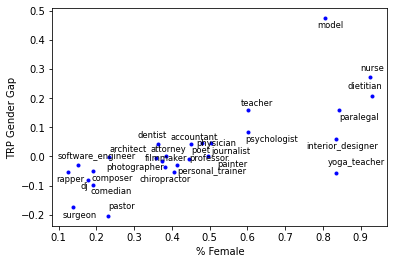

In [ ]:
plot_gender_gap(prob_pi_f, gap_f, occupation_dict, 'F')

In [ ]:
corr_w = np.corrcoef(prob_pi_f, gap_f)
print('Correlation: ', corr_w[0,1])

Correlation:  0.74161268363547


## Gender imbalance and compounding factor

In [ ]:
def g_imbalance(y, g, gender='F'):

  '''
  y:        list/vector of true labels
  g:        list of genders ('M', 'F') corresponding to y
  gender:   string indicating whether the imbalnce 
            should be calculated from the female
            ('F') or male ('M') perspective with
            default 'F'

  returns a list of imbalances from the perspective of the chosen
  gender sorted by the occupation code in ascending order
  '''
  
  if gender=='F':
    g_imbalance = prob_pi(y,g,gender='F')/prob_pi(y,g,gender='M')

  if gender=='M':
    g_imbalance = prob_pi(y,g,gender='M')/prob_pi(y,g,gender='F')

  return(g_imbalance)

In [ ]:
def compounding_factor(tpr_m, tpr_f, gender='F'):

  '''
  tpr_m:    list of TPRs for male
  tpr_f:    list of TPRs for female
  gender:   string indicating whether the compounding  
            factor should be calculated from the female
            ('F') or male ('M') perspective with
            default 'F'

  returns a list of compouning factors for the chosen
  gender sorted by the occupation code in ascending order
  '''

  if gender=="F":
    comp_fac = tpr_f/tpr_m
  if gender == "M":
    comp_fac = tpr_m/tpr_f

  return(comp_fac)

In [ ]:
imbalance_f = g_imbalance(np.array(bio_test_pred), g, gender='F')
comp_fact_f = compounding_factor(tpr_m, tpr_f, gender='F')

In [ ]:
df2 = pd.DataFrame(list(zip(imbalance_f, comp_fact_f)), columns =['Gender imbalance', 'Compounding factor'])
print('--------------- g = female ---------------')
display(df2)

--------------- g = female ---------------


,Gender imbalance,Compounding factor
0,0.639024,1.003442
1,0.310764,0.996325
2,0.620751,0.980255
3,0.671642,0.919355
4,0.219388,0.874125
5,0.244332,0.935124
6,0.588372,1.047826
7,8.964286,1.358606
8,0.169492,0.853625
9,0.536193,0.951726


## Load predictions on scrubbed test dataset

In [ ]:
results_scrub = pd.read_csv(alldatapath+"/scrub.results.csv")
scrub_test_pred = results_scrub['predicted labels']

## TPR, TPR gender gap and correlation between TPR gender gap and $\pi_{female,y}$ on the scrubbed test dataset

In [ ]:
tpr_m_scrub, tpr_f_scrub = tpr(np.array(scrub_test_pred), np.array(test_labels), g)
gap_f_scrub = gap(tpr_m_scrub, tpr_f_scrub, gender= 'F')
corr_w = np.corrcoef(prob_pi_f, gap_f_scrub)
print('Correlation: ', corr_w[0,1])

Correlation:  0.689206668699241


## Plot $\text{Gap}_{female,y}$ against $\pi_{female,y}$ for original compared to scrubbed test dataset

In [ ]:
def plot_gender_gap_two_sets(prob_pi_g_w, gap_g_w, prob_pi_g_wo, gap_g_wo, gender='F'):

  '''
  prob_pi_g_w:       list of probabilities for occupations for the chosen
                     gender on the set with gender indicators
  gap_g_w:           list of TPR gender gaps for the chosen
                     gender on the set with gender indicators
  prob_pi_g_wo:      list of probabilities for occupations for the chosen
                     gender on the set without gender indicators
  gap_g_wo:          list of TPR gender gaps for the chosen
                     gender on the set without gender indicators
  gender:            chosen gender with 'F' as default

  returns a plot of the TPR gender gaps against the probability
  of a gender given the occupation for both the set with and the set without
  gender indicators including trendlines
  '''

  import matplotlib.pyplot as plt
  from sklearn.linear_model import LinearRegression

  # regressions for trendlines
  regr_w = LinearRegression()
  regr_w.fit(prob_pi_g_w.reshape(-1, 1), gap_g_w)
  pred_w = regr_w.predict(prob_pi_g_w.reshape(-1, 1))
  regr_wo = LinearRegression()
  regr_wo.fit(prob_pi_g_wo.reshape(-1, 1), gap_g_wo)
  pred_wo = regr_wo.predict(prob_pi_g_wo.reshape(-1, 1))

  # scatterplot
  w, = plt.plot(prob_pi_g_w, gap_g_w, 'bo', label = "with gender indicators")
  plt.plot(prob_pi_g_w, pred_w, color='blue')
  wo, = plt.plot(prob_pi_g_wo, gap_g_wo, 'c^', label = "without gender indicators")
  plt.plot(prob_pi_g_wo, pred_wo, color='c')
  
  # x and y labels
  if gender=="F":
    plt.xlabel("% Female")
  else:
    plt.xlabel("% Male")
  plt.ylabel("TRP Gender Gap")

  # add legend 
  plt.legend(loc='upper left')
  
  # show plot
  plt.show()

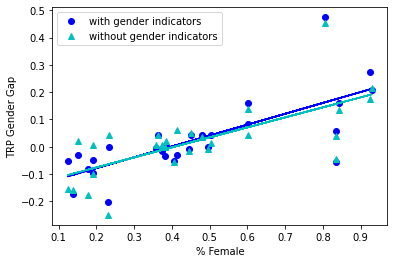

In [ ]:
plot_gender_gap_two_sets(prob_pi_f, gap_f, prob_pi_f, gap_f_scrub, gender='F')

Gender imbalance and compounding factor for scrubbed test dataset

In [ ]:
imbalance_f_scrub = g_imbalance(np.array(scrub_test_pred), g, gender='F')
comp_fact_f_scrub = compounding_factor(tpr_m_scrub, tpr_f_scrub, gender='F')

In [ ]:
df3 = pd.DataFrame(list(zip(imbalance_f_scrub, comp_fact_f_scrub)), columns =['Gender imbalance', 'Compounding factor'])
print('--------------- g = female ---------------')
display(df3)

--------------- g = female ---------------


,Gender imbalance,Compounding factor
0,0.671429,1.031178
1,0.352324,1.061956
2,0.630146,1.006303
3,0.707692,0.910467
4,0.259259,0.873271
5,0.292566,1.008417
6,0.589450,1.050526
7,10.666667,1.411858
8,0.134328,0.698210
9,0.597484,0.999068


## Proportion of compounding factors pulled towards 1 after scrubbing

In [ ]:
# percentage of compounding factors which are pulled towards 1
dif = comp_fact_f_scrub-comp_fact_f
pos=0
neg=0
for i in range(len(comp_fact_f)):
  if comp_fact_f[i]>1 and dif[i]<0:
    pos = pos+1
  if comp_fact_f[i]<1 and dif[i]>0:
    neg = neg+1
print('total: ', np.round(np.sum(pos+neg)/len(comp_fact_f), decimals=3))
print('with compounding factor > 1: ', np.round(pos/len(comp_fact_f), decimals=3))
print('with compounding factor < 1: ', np.round(neg/len(comp_fact_f), decimals=3))

total:  0.607
with compounding factor > 1:  0.286
with compounding factor < 1:  0.321
